# Data Preprocessing

This notebook shows 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import nltk
from nltk.corpus import wordnet
import sklearn
import seaborn as sns
import unicodedata
import inflect

import sys
sys.path.append('..movie-classifier/preprocessing')

In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

path = '../data/movies_metadata.csv'

df = pd.read_csv(path)

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df = pd.concat([df['release_date'], df['title'], df['overview'], df['genres']], axis=1)

# remove duplicates
duplicate_rows = df[df.duplicated()]
df.drop(duplicate_rows.index, inplace=True)

#### Drop the NaN rows where either title or overview is NaN

In [5]:
# convert empty string to NaN
df['overview'].replace('', np.nan, inplace=True)
df.dropna(subset=['release_date', 'title', 'overview'], inplace=True)

# the release date is no longer necessary, because NaN are cleared
del df['release_date']
# df.info()
# df.describe()

#### Drop rows with no overview info or blank

In [6]:
reg_404 = "^not available|^no overview"
overview_not_found = df['overview'].str.contains(reg_404, regex=True, flags=re.IGNORECASE)
overview_blank = df['overview'].str.isspace()

df.drop(df[overview_not_found].index, inplace=True)
df.drop(df[overview_blank].index, inplace=True)
df.describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,title,overview,genres
count,44253,44253,44253
unique,41160,44223,4042
top,Cinderella,No movie overview available.,"[{'id': 18, 'name': 'Drama'}]"
freq,11,3,4885


In [7]:
df

,title,overview,genres
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]"
...,...,...,...
45460,Robin Hood,"Yet another version of the classic epic, with ...","[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name..."
45462,Century of Birthing,An artist struggles to finish his work while a...,"[{'id': 18, 'name': 'Drama'}]"
45463,Betrayal,"When one of her hits goes wrong, a professiona...","[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam..."
45464,Satan Triumphant,"In a small town live two brothers, one a minis...",[]


#### Transform column genre

In [8]:
def extract_genres(genres_str):
    genres_str = genres_str.replace("'", '\"')
    genres_json = json.loads(genres_str)
    genres_list = []
    for elem in genres_json:
        genres_list.append(elem['name'])
    return genres_list

In [9]:
# remove rows with no genres, since they don't provide any information
df.drop(df[df['genres'] == '[]'].index, inplace=True)

# transform genres from string to list
temp_genre = df['genres'].apply(extract_genres)

In [10]:
# test conversion to list went ok
g_set = set()
for i, row in df['genres'].iteritems():
    reg = ''
    for genre in temp_genre[i]:
        reg = reg + '(?=.*' + genre + ')'
        g_set.add(genre)
    if not re.search(reg, row) or len(temp_genre[i]) == 0:
        print('FAILED: at i =', i , row)
        print(reg)
        break

In [11]:
df['genres'] = temp_genre

#### One-hot encoding

In [12]:
# https://stackoverflow.com/questions/47026585/unhashable-type-list-error-with-get-dumies
# res = pd.get_dummies(df.genres.apply(pd.Series).stack()).sum(level=0)
# df = pd.concat([df, res], axis=1, sort=False)
# df.head(3)

#### Visualise movie genres' distribution

In [13]:
all_genres = sum(df['genres'], [])
genre_types = set(all_genres)
len(genre_types)

20

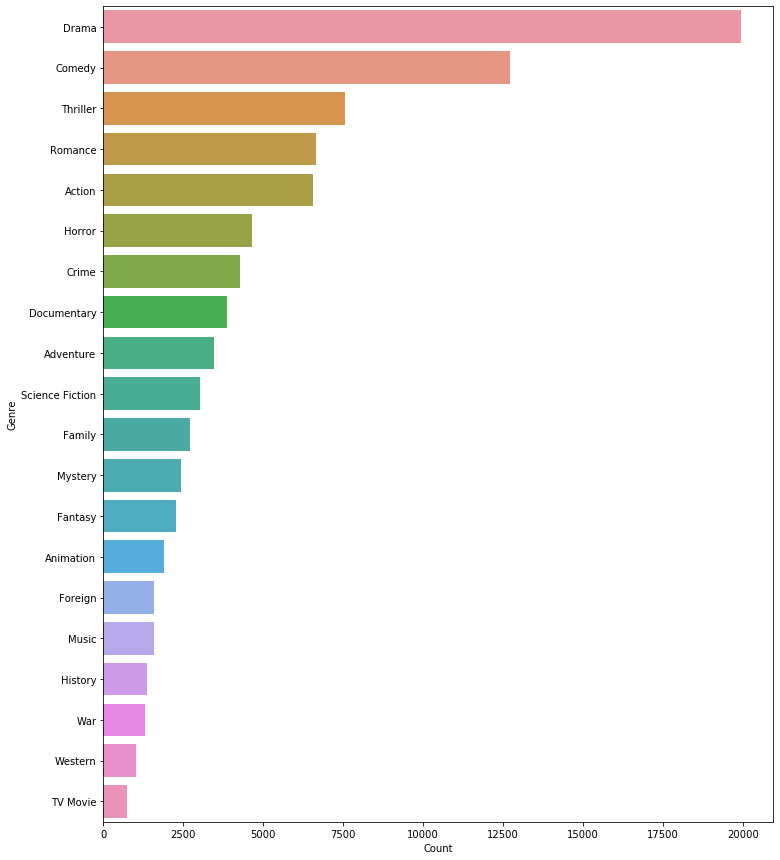

In [14]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
plt.show()

In [15]:
def to_lower(text):
    return text.lower()

def remove_specials(sentence):
    sentence = sentence.replace('-', ' ')
    sentence = re.sub(r'[^\w\s]', '', sentence)
    return sentence

def remove_stopwords(tokens):
    words = []
    for word in tokens:
        if word not in nltk.corpus.stopwords.words('english'):
            words.append(word)
    return words

def replace_nums2words(tokens):
    e = inflect.engine()
    words = []
    for word in tokens:
        if word.isdigit():
            words.append(e.number_to_words(word).replace(',', ''))
        else:
            words.append(word)
    return words

def lemmatisation(tokens):
    pos_tag = nltk.pos_tag(tokens)
    lemmatiser = nltk.WordNetLemmatizer()
    wornet_tags = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    words = []
    for word, tag in pos_tag:
        proper_tag = wornet_tags.get(tag[0].upper(), wordnet.NOUN)
        words.append(lemmatiser.lemmatize(word, proper_tag))
    return words

def text_preprocessing(text):
    # 1. Transform all characters in lowercase
    text = to_lower(text)

    # 2. Replace all compatibility characters with their equivalents (i.e. accented)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf8')

    # 3. Remove special characters (punctuation, extra spaces)
    text = remove_specials(text)

    # 4. Tokenization
    toks = nltk.word_tokenize(text)

    # 5. Stopwords removal
    toks = remove_stopwords(toks)

    # 5. Convert to number to text representation
    toks = replace_nums2words(toks)
    
    # 6. Lemmatisation
    toks = lemmatisation(toks)

    return toks

In [ ]:
df['overview'] = df['overview'].apply(text_preprocessing)

In [ ]:
def flatten_overview_words(column):
    all_words = []
    for overview in column.values.tolist():
        for word in overview:
            all_words.append(word)
    return all_words

def freq_words(x, terms = 30):
    fdist = nltk.FreqDist(x) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 

    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 

    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()
    
# print 100 most frequent words 
freq_words(flatten_overview_words(df['overview']), 50)

In [ ]:
new_df = df['title']
str_overview = df['overview'].apply(lambda x: ' '.join(x))
new_df = pd.concat([new_df, str_overview], axis=1)
new_df =  pd.concat([new_df, df['genres']], axis=1)
new_df['genres'] = new_df['genres'].apply(lambda x: ','.join(x))
new_df['overview'] = new_df['title'].apply(to_lower).astype(str) + ' ' + new_df ['overview']
new_df

In [ ]:
new_df.to_csv("../data/movies_data_ready.csv", index=False)